In [158]:
# Relevant Libraries
import sys
sys.path.append("./../..")
from PIL import Image

from InternalLibrary.StatisticalFunctions import *
from InternalLibrary.SimulatorPackage import Simulator_noGPU

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import torch

from tqdm import tqdm
import _pickle as pickle

import sympy as sym

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, SNPE_A, SNPE_C, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

# Red Blood Cells Model

## Description

![](./images/bloodcell.png "BloodCell")

Red Blood Cells is a two-layer model with one hidden variable y_t for the membrane-cortex attachment and a measurable variable
x_t for the membrane outer layer, Fig. S1. 
Dynamics follows the equations,
\begin{align*}
    \dot{x}_t &= \mu_x \left( -k_x x_t + k_{int}y_t\right) + \sqrt{2\mu_xD_x} \eta_x \\
    \dot{y}_t &= \mu_y \left( -k_y y_t + k_{int}x_t + f_t \right) + \sqrt{2\mu_yD_y} \eta_y \\
    \dot{f}_t &= -\frac{f_t}{\tau} + \sqrt{\frac{2\epsilon^2}{\tau}} \, \eta_f
\end{align*}
where $k_x$, $k_y$, $k_int$ are effective stiffnesses related to the immobilizing procedure of the RBC (bare stiffness, $k_x$); the internal RBC
rigidity ($k_y$); and the membrane-cortex coupling ($k_int$). \
$\mu_x$, $\mu_y$ and $\eta_x$, $\eta_y$ are bare mobilities and white noises for x and y, while $D_x = k_BT \mu_x$, $D_y = k_BT \mu_y$.\
$f_t$ is the stochastic active force 

## Hyperparameters of the traces

Let us define the parameters of our model and simulation. As this is a highly stochastic model, we will run the simulation for a large number of particles.

In [159]:
dt = 1e-6# The time step size for the simulation. This is the amount of time that passes in the model for each step of the simulation
Sample_frequency = 25_000 # The sampling frequency. This is the number of samples that are recorded per unit time
DeltaT = 1/Sample_frequency # The sampling period. This is the amount of time that passes in the model between each sample that is recorded
TotalT = 13 # The total time for the simulation. This is the total amount of time that the simulation is intended to represent
transient = 3
t_corr = TotalT/50

In [160]:
time_steps_amount = np.int64((TotalT-transient)/dt) # Number of steps
sampled_point_amount = np.int64((TotalT-transient)/DeltaT) # Number of sampled points
sampling_delta_time_steps = np.int64(DeltaT/dt) # Number of steps between samples
t = np.linspace(0., TotalT - transient, sampled_point_amount) # Time array

In [161]:
# Limits for the parameters (kbT=3.8 pN nm)
prior_limits = {
    "mu_y": [1e4, 140e4],
    "k_y": [1.5e-2, 30e-2],
    "k_int": [1e-3, 6e-3],
    "tau": [2e-2, 20e-2],
    "eps": [0.5, 6],
}

In [162]:
tnice = [DeltaT for t in range(sampled_point_amount - 1)]

In [163]:
# Dummy call to compile the simulator
theta, theta_torch = get_theta_from_prior(prior_limits, 1)
Simulator_noGPU(0.1, 0.1, 0.5, theta);

## Get simulations & summary statistics

In this section you can load the data from file and select the pool of summary statistics you want to work with (suggested approach). Otherwise, you can compute some simulation on the fly and then get the correspondend summary statistics. 

### If you want to compute the traces

In [164]:
n_sim = 10

In [165]:
%%time
theta, theta_torch = get_theta_from_prior(prior_limits, n_sim)
x_trace, y_trace, f_trace = Simulator_noGPU(dt, DeltaT, TotalT, theta, transient_time = transient)

CPU times: user 27.2 s, sys: 96.1 ms, total: 27.3 s
Wall time: 27.2 s


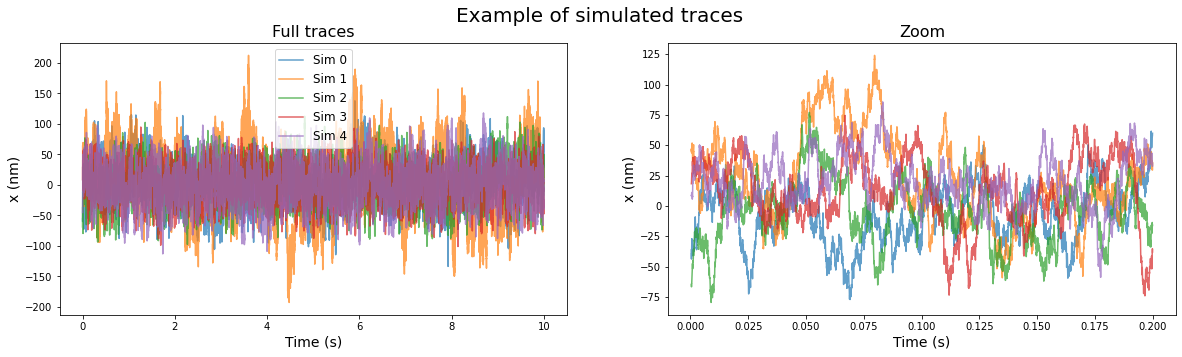

In [166]:
# Example of simulated traces
plt.figure(figsize=(20, 5))
plt.suptitle("Example of simulated traces", fontsize=20)

plt.subplot(121)
for i in range(min([n_sim, 5])):
    plt.plot(t, x_trace[i], label=f"Sim {i}", alpha=0.7)
plt.title("Full traces", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("x (nm)", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
for i in range(min([n_sim, 5])):
    plt.plot(t[10:5000], x_trace[i, 10:5000], label=f"Sim {i}", alpha=0.7)
plt.title("Zoom", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("x (nm)", fontsize=14);


In [ ]:
%%time
# Compute the summary statistics from the simulations 
selected_stats = ["s_redx"]
z_score = False

first = True
for i in range(n_sim):
    print("i = ", i+1, end="\r")  
    summary_stats = compute_summary_statistics(x_trace[i], theta[:,i])
    s_i = select_summary_statistics(summary_stats, selected_stats, DeltaT, z_score=z_score)
    
    if first:
        s_tot = s_i
        theta_tot = torch.from_numpy(summary_stats["theta"]).to(torch.float32)
        summary_stats_length = [len(summary_stats[s]) for s in selected_stats]
        print("Length of each summary statistics: ", summary_stats_length)
        first = False
    else:
        s_tot = torch.cat((s_tot, s_i), dim=0)
        theta_tot = torch.cat((theta_tot, torch.from_numpy(summary_stats["theta"]).to(torch.float32)), dim=1)

print("s_tot shape: ", s_tot.shape, ",  theta_tot shape: ", theta_tot.shape)

### If you want to load from file

In [197]:
%%time
# Hyperparameters
selected_stats = ["s_redx", "Cxx"] # selected summary statistics
z_score = False # z-score normalization of the summary statistics
cl_log = 5 # post-subsampling of Cxx and s_redx (-1 for no post-subsampling)
cl_lin = -1
fit_corr = False
fit_s_redx = False # Implemented: "exp" or "simple"
skiped_simulations = 0

# List file in the directory SummaryStatistics
#files = os.listdir("../../Data/SummaryStatistics/20240515/")[:-1]
files = [os.path.join(root, file)
        for root, _, files in os.walk("../../Data/SummaryStatistics/")
        for file in files][1:-1]
print("Reading ", len(files), " file for a total of ", 200*len(files), " simulations... \n")
loaded_simul = 0

# Pipeline from the n_sim simulations to the be ready for training
first = True
for file in files:
    print("Reading file", file, " i =", loaded_simul, " / ", 200*len(files), end='\r')
    with open(f"{file}", "rb") as f:
        summary_stats_batch = pickle.load(f)
    
    for i in range(len(summary_stats_batch)):
        # Here handle the local simulations
        summary_stats = summary_stats_batch[i]
        s_i = select_summary_statistics(summary_stats, selected_stats, DeltaT,
                z_score=z_score, cl_lin=cl_lin, cl_log=cl_log, fit_cxx=fit_corr, fit_s_redx=fit_s_redx)
        
        if s_i == None: 
            skiped_simulations += 1
            print("Skiped simulations: ", skiped_simulations, end='\r')
            continue
        
        if first:
            s_tot = s_i
            theta_tot = torch.from_numpy(summary_stats["theta"]).to(torch.float32)
            summary_stats_length = [len(summary_stats[s]) for s in selected_stats]
            print("Length of each summary statistics: ", summary_stats_length)
            first = False
        else:
            s_tot = torch.cat((s_tot, s_i), dim=0)
            theta_tot = torch.cat((theta_tot, torch.from_numpy(summary_stats["theta"]).to(torch.float32)), dim=1)
        
        loaded_simul += 1

theta_tot = theta_tot.T

print("Loaded simulations", loaded_simul)
print("s_tot.shape", s_tot.shape)
print("theta_tot.shape", theta_tot.shape)

Reading  468  file for a total of  93600  simulations... 

Length of each summary statistics:  [5, 5]20240714/20240714-074855_200sims_process14499.pkl  i = 0  /  93600
Loaded simulations 93600SummaryStatistics/20240713/20240713-182010_200sims_process12916.pkl  i = 93400  /  9360000
s_tot.shape torch.Size([93600, 10])
theta_tot.shape torch.Size([93600, 5])
CPU times: user 2min 55s, sys: 31.9 s, total: 3min 26s
Wall time: 17min 36s


In [169]:
print(summary_stats.keys())

dict_keys(['Cxx', 'Cxx_cl_lin', 'Cxx_cl_log', 'Cxx_fit', 's_red1', 's_red2', 's_redx', 's_redx_cl_lin', 's_redx_cl_log', 's_redx_fit', 'psdx', 'ts_psdx', 'ts_x', 'hermite', 'modes', 'tucci', 'theta'])


### Visualization and normalization of $\theta$

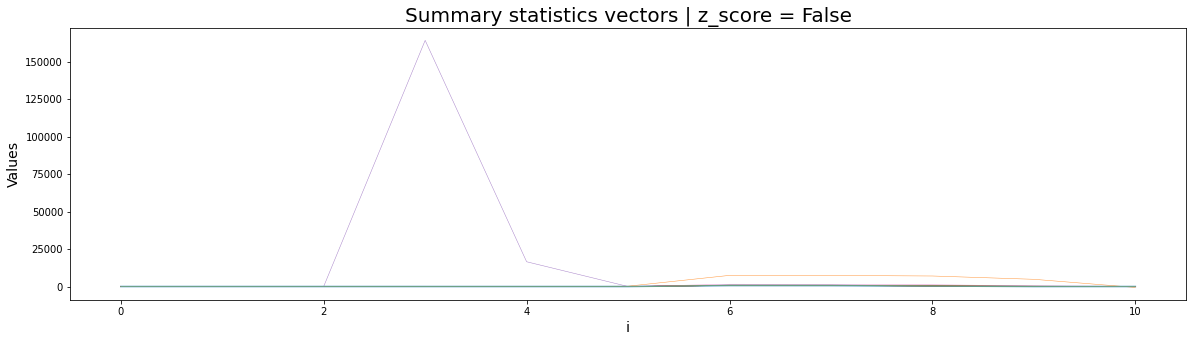

In [170]:
plt.figure(figsize=(20, 5))
plt.title("Summary statistics vectors | z_score = " + str(z_score), fontsize=20)
plt.xlabel("i", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.plot(s_tot[0, :], alpha=0.8)

for i in range(1, min([s_tot.shape[0], 20])):
    plt.plot(s_tot[i, :], lw=0.5, alpha=0.8)

plt.vlines(x=np.cumsum(summary_stats_length)-1, ymin=-4, ymax=5, color='r', linestyles='dashed');

In [198]:
# Rescale the parameters in [-0.5, 0.5]
theta_tot_norm = rescale_theta(theta_tot, prior_limits)

## Inference

In this section we use the SBI library to infere the five parameters of the dynamical model. The plain pipeline is enriched to provide some quick analysis on the fly (for instace, repeate the fitting procedure and keep the posterior with the higher score)

In [199]:
# Prior distribution for sbi
prior_box = get_prior_box(prior_limits)

## Prior box if theta normalized:
prior_box = utils.torchutils.BoxUniform(low=torch.tensor([-0.5]*len(prior_limits)), high=torch.tensor([0.5]*len(prior_limits)))

prior, num_parameters, prior_returns_numpy = process_prior(prior_box)

In [200]:
# # Plain single execution
# infer = SNPE(prior=prior)
# inferece = infer.append_simulations(theta_tot_norm, s_tot)

# density_estimator = infer.train(num_atoms=20, show_train_summary=False, 
#                                     training_batch_size=500, learning_rate=0.005,
#                                     stop_after_epochs=50)
# posterior = infer.build_posterior(density_estimator)

In [201]:
%%time
# Train the model (multiple time eventually, keep the best)
n_trials = 1
compare_MSE = False

nn_performance = []
mse_mean = []
mse_mode = []

best = 0
for i in range(n_trials):
    # Call infer form sbi
    infer = SNPE(prior=prior)
    #inferece = infer.append_simulations(theta_tot, s_tot)
    inferece = infer.append_simulations(theta_tot_norm, s_tot)

    # Train the model
    density_estimator = infer.train(num_atoms=20, show_train_summary=False, 
                                    training_batch_size=500, learning_rate=0.005,
                                    stop_after_epochs=50)
    print("\n Training ", i+1, " / ", n_trials, ": best validation performance: ", 
          round(infer.summary["best_validation_log_prob"][0], 3))
    nn_performance.append(infer.summary["best_validation_log_prob"][0])

    # Test the model on sigma (entropy production)
    if compare_MSE:
        posterior = infer.build_posterior(density_estimator)
        sigma_true, sigma_posterior = CompareTheoreticalSigma(posterior, 10, 1e5, return_theta=False,
                  selected_stats=selected_stats, cl_log=5)
        mean_array = np.mean(sigma_posterior, axis=1)
        mode_array = np.array([get_mode(sigma_posterior[i]) for i in range(len(sigma_true))])
        mse_mean.append(np.mean((sigma_true.reshape(sigma_true.shape[0])-mean_array)**2))
        mse_mode.append(np.mean((sigma_true.reshape(sigma_true.shape[0])-mode_array)**2))

    # Save the best model (nn performance)
    if infer.summary["best_validation_log_prob"][0] > best:
        best = infer.summary["best_validation_log_prob"][0]
        best_density_estimator = density_estimator
        best_infer = infer
print("Best validation performance: ", best)  

# Build the posterior
posterior = best_infer.build_posterior(best_density_estimator)

 Neural network successfully converged after 243 epochs.
 Training  1  /  1 : best validation performance:  6.287
Best validation performance:  6.286500244140625
CPU times: user 1h 41min 14s, sys: 5.49 s, total: 1h 41min 19s
Wall time: 13min 53s


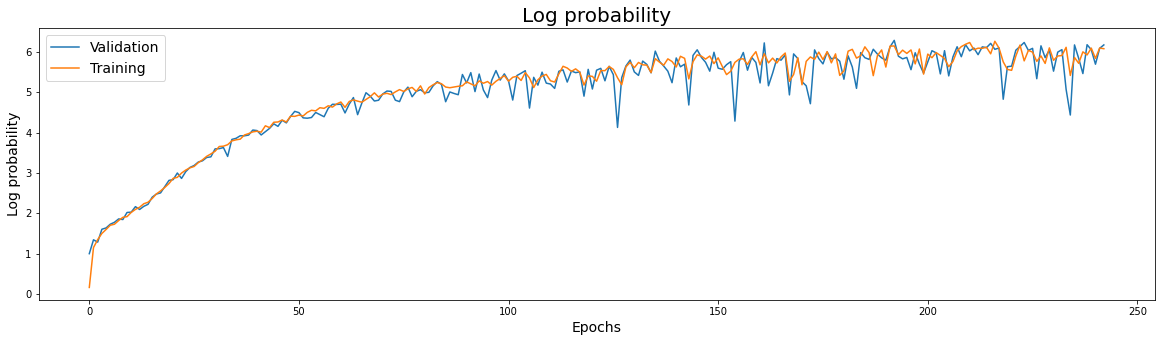

In [202]:
plt.figure(figsize=(20, 5))
plt.title("Log probability", fontsize=20)
plt.plot(best_infer.summary["validation_log_probs"], label="Validation")
plt.plot(best_infer.summary["training_log_probs"], label="Training")
plt.legend(fontsize=14)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Log probability", fontsize=14);

In [203]:
if compare_MSE:
    plt.figure(figsize=(15, 5))
    plt.title("Network performance and entropy production", fontsize=20)
    colors = sns.color_palette("colorblind", n_colors=len(nn_performance))
    for i in range(len(nn_performance)-1):
        if i == 0: 
            plt.scatter(nn_performance[i], mse_mean[i], marker='x', s=30, color=colors[i], label="Mean")
            plt.scatter(nn_performance[i], mse_mode[i], marker='v', s=30, color=colors[i], label="Mode")
        else:
            plt.scatter(nn_performance[i], mse_mean[i], marker='x', s=30, color=colors[i])
            plt.scatter(nn_performance[i], mse_mode[i], marker='v', s=30, color=colors[i])
    plt.xlabel("Log probability", fontsize=14)
    plt.ylabel(r"MSE($\sigma^*$, $\hat{\sigma}$) | 10 trials", fontsize=14)
    plt.legend(loc="upper left", fontsize=12)
    plt.yscale("log")
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray');

In [204]:
# # Save a posterior
# with open("./data/posterior_9_8.pkl", "wb") as f:
#     pickle.dump(posterior, f)

In [205]:
# # Load a posterior
# with open("./data/posterior_7.pkl", "rb") as f:
#     posterior = pickle.load(f)

In [206]:
# Get the observed trace
theta_true, theta_torch_true = get_theta_from_prior(prior_limits, 1)
x_trace_true, y_trace_true, f_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, theta_true, transient_time=transient)
print("theta_true.shape: ", theta_true.shape)
print("x_trace_true.shape: ", x_trace_true.shape)

theta_true.shape:  (5, 1, 1)
x_trace_true.shape:  (1, 249999)


In [207]:
# Compute the summary statistics for the observed trace
summary_stats_true = compute_summary_statistics(x_trace_true[0], theta_true[:, 0])
s_true = select_summary_statistics(summary_stats_true, selected_stats, DeltaT, z_score=z_score, 
                                   cl_lin=cl_lin, cl_log=cl_log, fit_cxx=fit_corr, fit_s_redx=fit_s_redx)

In [208]:
# Sample from the posterior
samples = posterior.sample((int(1e5),), x=s_true, show_progress_bars=False)

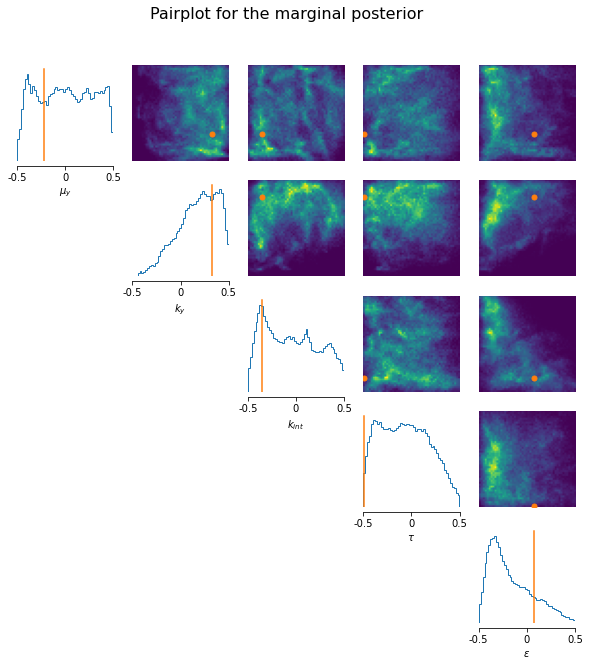

In [209]:
# Pairplot
label_theta = [r"$\mu_y$", r"$k_y$", r"$k_{int}$", r"$\tau$", r"$\varepsilon$"]
prior_limits_list = get_prior_limit_list(prior_limits)

prior_limits_list = [[-0.5, 0.5] for _ in range(len(prior_limits_list))]


# Rescaling the parameters
_ = analysis.pairplot(samples, points=[rescale_theta(theta_torch_true.T, prior_limits)], 
                      limits=prior_limits_list, figsize=(10, 10), 
                      title = "Pairplot for the marginal posterior",
                      labels=label_theta)

## Entropy production & Performances

Two way to compute entropy production rate:
- Theoretical: use the parameters of the model to directly compute the entropy
$$
\sigma_{analytical} = \frac{{\mu_y \cdot \varepsilon^2}}{{1 + k_y \cdot \mu_y \cdot \tau - \frac{{k_{int}^2 \cdot \mu_x \cdot \mu_y \cdot \tau^2}}{{1 + k_x \cdot \mu_x \cdot \tau}}}}
$$
- Empirical: use the traces $x_t, y_t, f_t$ to compute the entropy

### SBI posterior

Here we analyze the SBI posterior. Specifically, we want to reconstruct the theoretical entropy production from the inferred parameters.

In [ ]:
%%time
n_trials = 40
sigma_true, sigma_posterior, theta_true = CompareTheoreticalSigma(posterior, n_trials, 1e5, selected_stats, cl_log=5, return_theta=True)

In [216]:
mode_array = np.array([get_mode(sigma_posterior[i]) for i in range(len(sigma_true))])
mean_array = np.mean(sigma_posterior, axis=1)
print("Corr(true_value, mode) = ", np.corrcoef(mode_array, sigma_true.reshape(n_trials,))[0, 1])
print("Corr(true_value, mean) = ", np.corrcoef(mean_array, sigma_true.reshape(n_trials,))[0, 1])

Corr(true_value, mode) =  0.8444035727914446
Corr(true_value, mean) =  0.8676735389454721


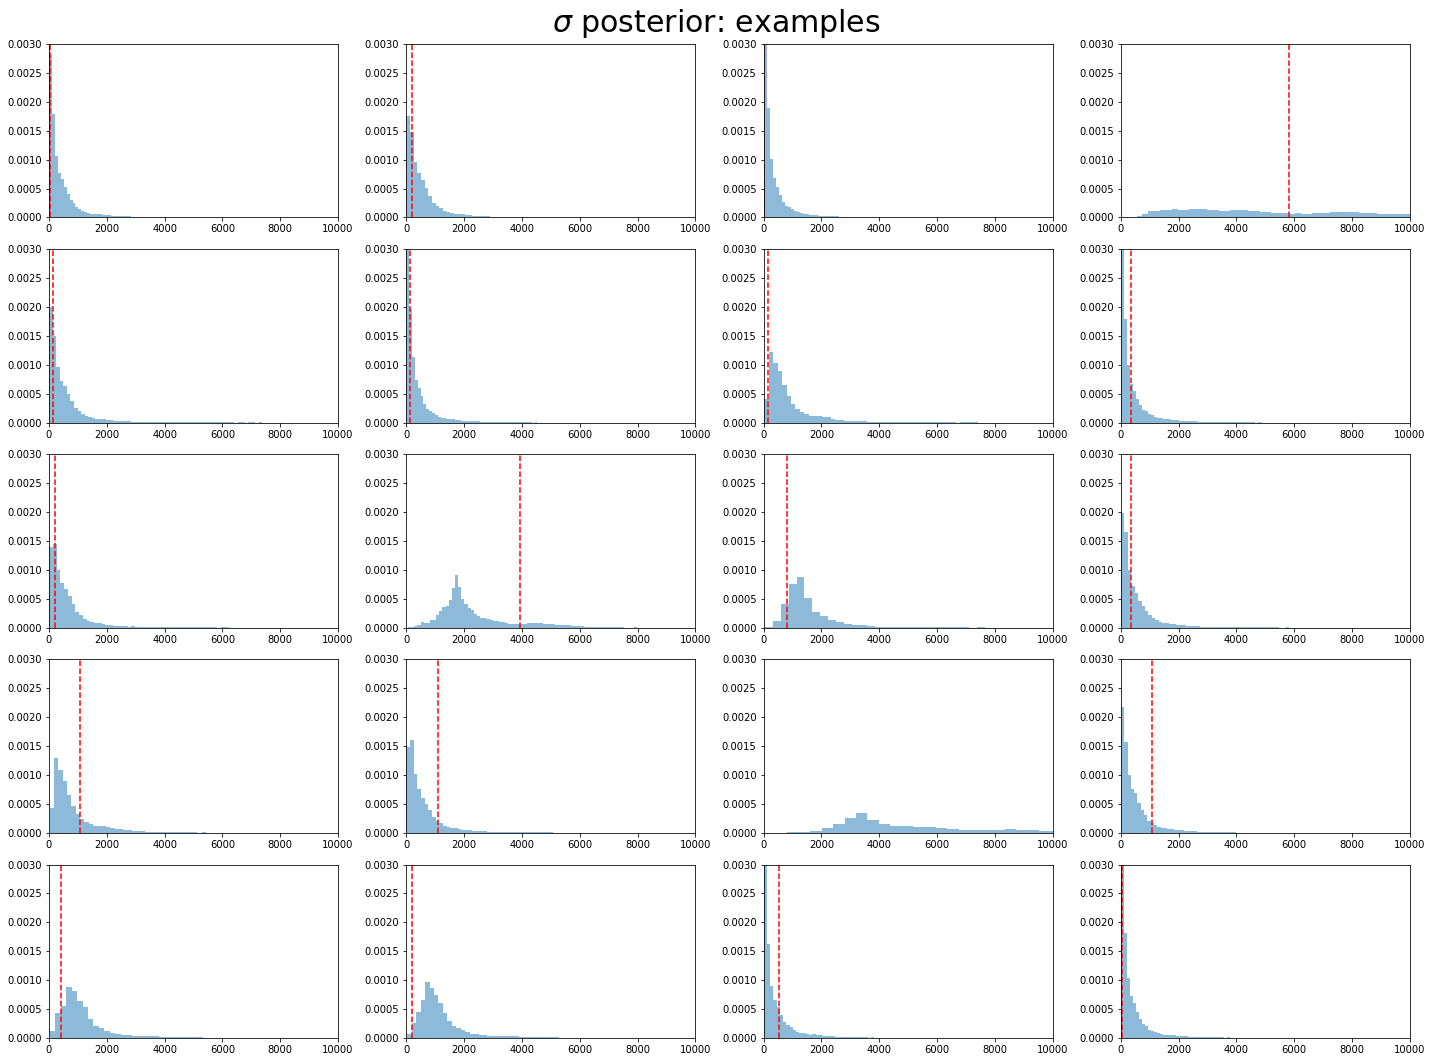

In [217]:
fig, ax = plt.subplots(5, 4, figsize=(20, 15))
fig.suptitle(r"$\sigma$ posterior: examples", fontsize=30)
for i in range(20):
    ax[i//4, i%4].hist(sigma_posterior[i], bins=100, density=True, alpha=0.5)
    ax[i//4, i%4].axvline(sigma_true[i], color='r', linestyle='--')
    #ax[i//4, i%4].axvline(get_mode(sigma_posterior[i]), color='g')
    ax[i//4, i%4].set_xlim(0, 10000)
    ax[i//4, i%4].set_ylim(0, 0.003)

fig.tight_layout()

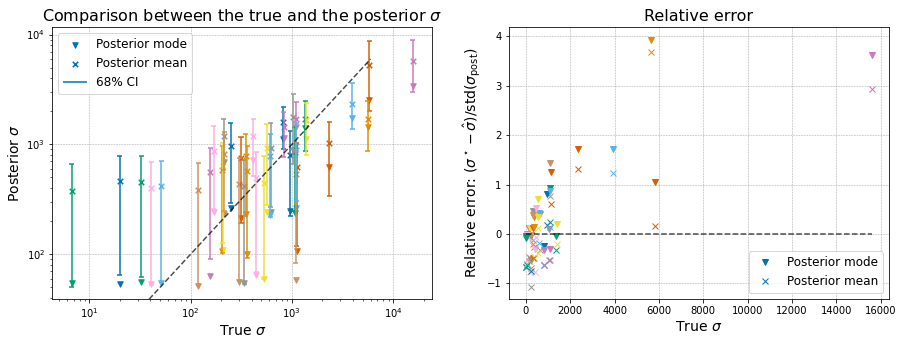

In [218]:
plt.figure(figsize=(15, 5))
colors = sns.color_palette("colorblind", n_colors=len(sigma_true))

plt.subplot(121)
for i in range(len(sigma_true)):
    mode = get_mode(sigma_posterior[i])
    mean = np.mean(sigma_posterior[i])
    cl = get_credibility_interval(sigma_posterior[i], 0.68)
    if i == 0:
        plt.scatter(sigma_true[i], mode, label=f"Posterior mode", s=30, marker="v", color=colors[i])
        plt.scatter(sigma_true[i], mean, label=f"Posterior mean", s=30, marker="x", color=colors[i])
        plt.vlines(sigma_true[i], cl[0], cl[1], color=colors[i], label="68% CI")
    else:
        plt.scatter(sigma_true[i], mode, s=30, marker="v", color=colors[i])
        plt.scatter(sigma_true[i], mean, s=30, marker="x", color=colors[i])
        plt.vlines(sigma_true[i], cl[0], cl[1], color=colors[i])
    
    cap_size = 0.05  # Adjust this value for the desired cap size
    cap_left = sigma_true[i] / (10 ** (cap_size / 2))
    cap_right = sigma_true[i] * (10 ** (cap_size / 2))
    plt.hlines(cl[0], cap_left, cap_right, color=colors[i])
    plt.hlines(cl[1], cap_left, cap_right, color=colors[i])

#plt.xlim([-100, 6e3])
plt.xscale("log")
#plt.ylim([-100, 6e3])
plt.yscale("log")
plt.plot([0, 6e3], [0, 6e3], color='black', linestyle='--', alpha=0.7)  
plt.xlabel(r"True $\sigma$", fontsize=14)
plt.ylabel(r"Posterior $\sigma$", fontsize=14)
plt.title(r"Comparison between the true and the posterior $\sigma$", fontsize=16)
plt.legend(loc="upper left", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

plt.subplot(122)
plt.title("Relative error", fontsize=16)
plt.xlabel("True $\sigma$", fontsize=14)
plt.ylabel(r"Relative error: $(\sigma^\star - \hat{\sigma})/\text{std}(\sigma_{\text{post}})$", fontsize=14)
for i in range(len(sigma_true)):
    mode = get_mode(sigma_posterior[i])
    mean = np.mean(sigma_posterior[i])
    std = np.std(sigma_posterior[i])
    if i == 0:
        plt.plot(sigma_true[i], (sigma_true[i] - mode)/std, 'v', label=f"Posterior mode", color=colors[i])
        plt.plot(sigma_true[i], (sigma_true[i] - mean)/std, 'x', label=f"Posterior mean", color=colors[i])
    else:
        plt.plot(sigma_true[i], (sigma_true[i] - mode)/std, 'v', color=colors[i])
        plt.plot(sigma_true[i], (sigma_true[i] - mean)/std, 'x', color=colors[i])

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
plt.hlines(y=0, xmin=0, xmax=np.max(sigma_true), color='black', linestyle='--', alpha=0.7)
plt.legend(loc="lower right", fontsize=12);

The following plot shows the impact of each single parameters (the true value) in the performances of the pipeline in terms of relative error and standard deviation of the posterior sigma.

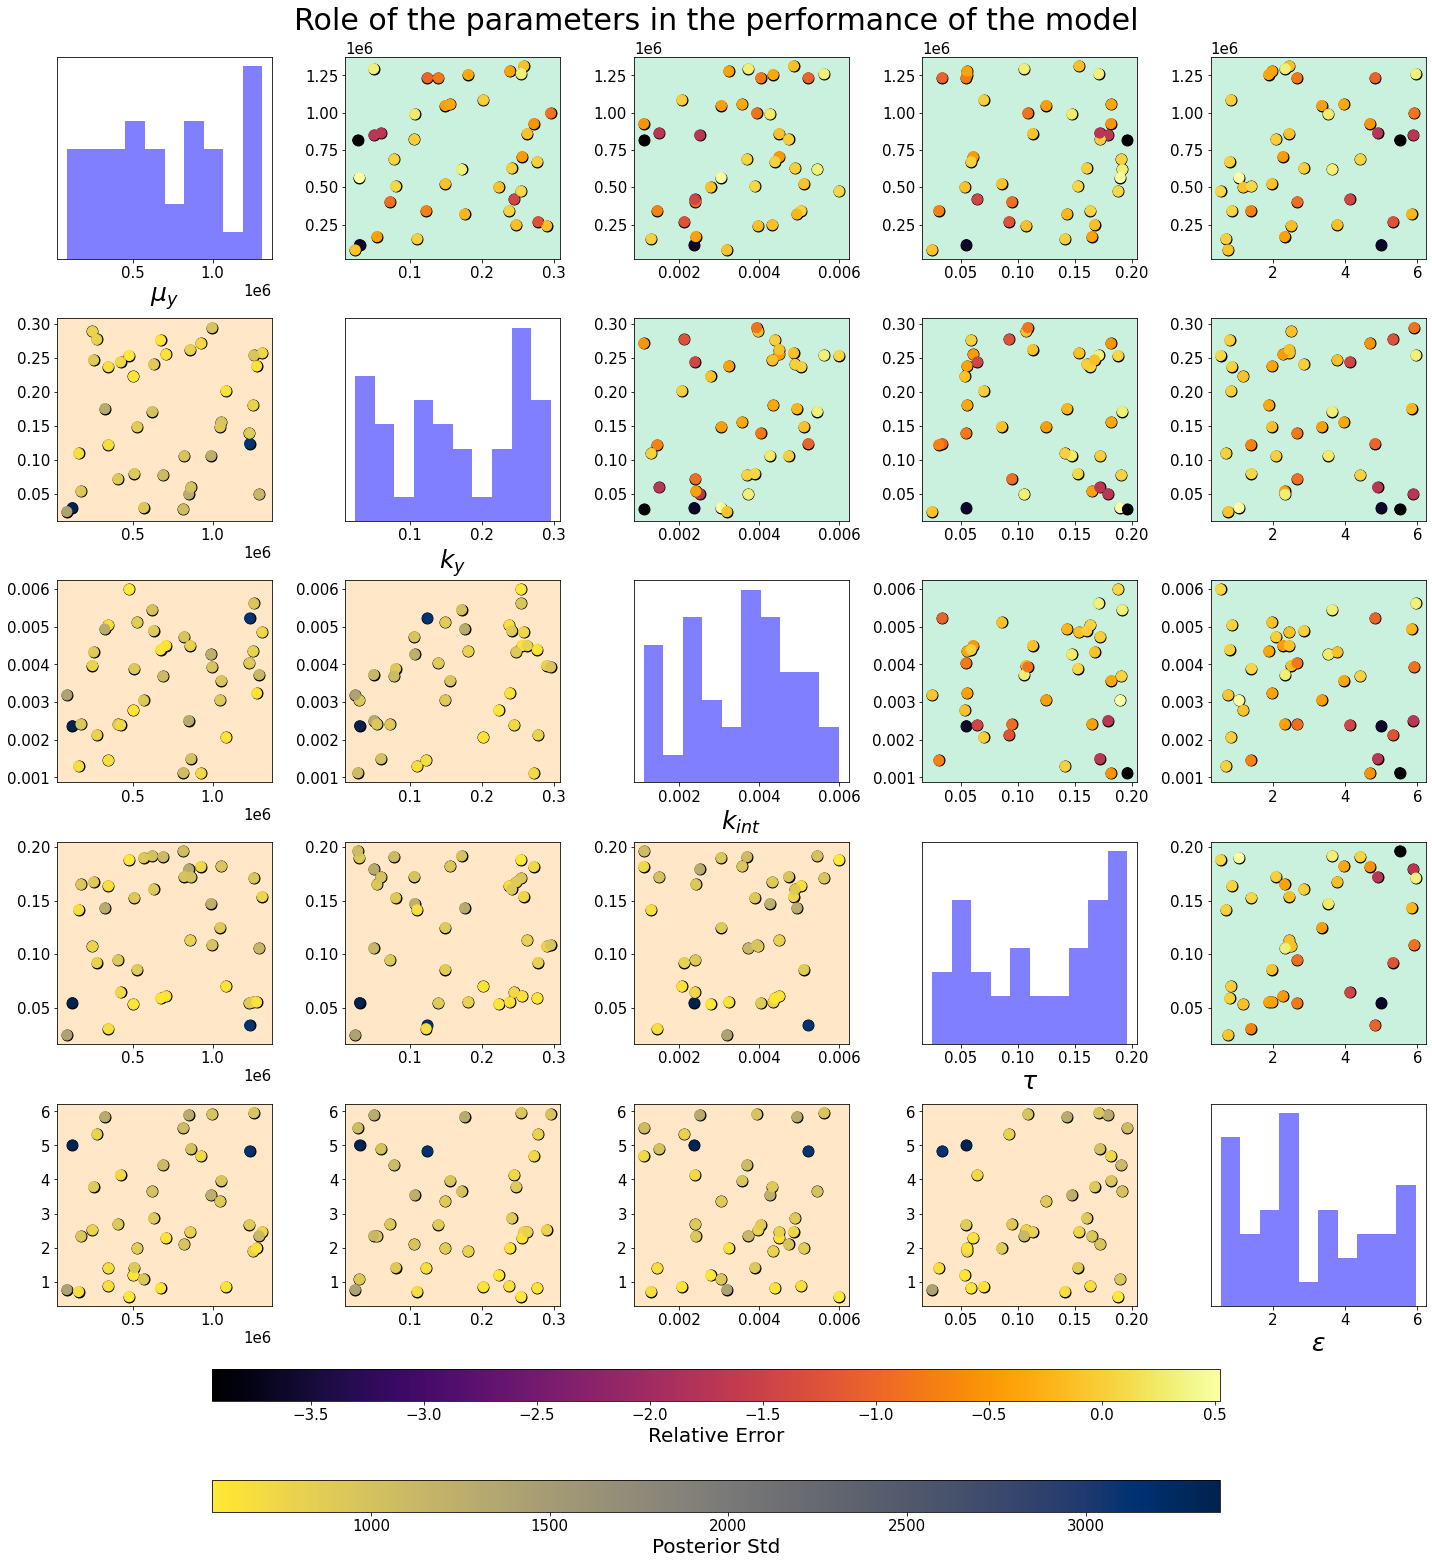

In [220]:
label_theta = [r"$\mu_y$", r"$k_y$", r"$k_{int}$", r"$\tau$", r"$\varepsilon$"]
prior_limits_list = get_prior_limit_list(prior_limits)

fig, axs = plt.subplots(5, 5, figsize=(20, 22))
fig.suptitle("Role of the parameters in the performance of the model", fontsize=30)

# Diagonal: sample from the prior
for i in range(5):
    ax = axs[i, i]
    ax.hist(theta_true[i], bins=10, alpha=0.5, color='blue')
    ax.set_xlabel(label_theta[i], fontsize=25)
    ax.set_yticks([])
    ax.xaxis.set_tick_params(labelsize=15)
    ax.xaxis.get_offset_text().set_fontsize(15)

# Upper triangular: scatter plot of the relative error
mode_array = np.array([get_mode(sigma_posterior[i]) for i in range(len(sigma_true))])
#err = (sigma_true - mode_array) / sigma_true
err = (mode_array - sigma_true.reshape(n_trials,)) / np.std(sigma_posterior, axis=1)
for i in range(5):
    for j in range(i + 1, 5):
        ax = axs[i, j]
        ax.scatter(theta_true[j], theta_true[i], c='black', s=120, alpha=1)
        scatter_err = ax.scatter(theta_true[j], theta_true[i], c=err, cmap="inferno", s=100, alpha=1)
        ax.set_facecolor('#CAF1DE')
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.yaxis.get_offset_text().set_fontsize(15)

# Lower triangular: scatter plot of the posterior std
post_std = np.array([np.std(sigma_posterior[i]) for i in range(len(sigma_true))])
for i in range(5):
    for j in range(i):
        ax = axs[i, j]
        ax.scatter(theta_true[j], theta_true[i], c='black', s=120, alpha=1)
        scatter_std = ax.scatter(theta_true[j], theta_true[i], c=post_std, cmap="cividis_r", s=100, alpha=1)
        ax.set_facecolor('#FFE7C7')
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.xaxis.get_offset_text().set_fontsize(15)

fig.tight_layout(rect=[0, 0, 1, 0.99])

# Add colorbars
fig.subplots_adjust(bottom=0.16)  # Make space at the bottom for colorbars
cbar_ax_err = fig.add_axes([0.15, 0.1, 0.7, 0.02])  # [left, bottom, width, height]
cbar_err = fig.colorbar(scatter_err, cax=cbar_ax_err, orientation='horizontal', label='Relative Error')
cbar_err.ax.tick_params(labelsize=15)  # Change the fontsize of the ticks
cbar_err.set_label('Relative Error', fontsize=20)  # Change the fontsize of the label
cbar_ax_std = fig.add_axes([0.15, 0.03, 0.7, 0.02])  # [left, bottom, width, height]
cbar_std = fig.colorbar(scatter_std, cax=cbar_ax_std, orientation='horizontal', label='Posterior Std Dev')
cbar_std.ax.tick_params(labelsize=15)  # Change the fontsize of the ticks
cbar_std.set_label('Posterior Std', fontsize=20)  # Change the fontsize of the label



### Marginalization of the single parameters

In this section, we try to evaluate $\sigma$ from the marginalized distributions of the parameters. We assume the error of each parameter to be the standard deviation of the marginal distribution and we neglect the correlations. 

In [43]:
def ErrorTheoreticalSigma(mean_params, err_params, mu_x = 2.8e4, k_x = 6e-3):
    mean_params = mean_params.reshape(5)
    err_params = err_params.reshape(5)
    mean_mu_y, mean_k_y, mean_k_int, mean_tau, mean_eps = mean_params
    err_mu_y, err_k_y, err_k_int, err_tau, err_eps = err_params

    mu_y, k_y, k_int, tau, eps = sym.symbols('mu_y k_y k_int tau eps')
    
    # Define the entropy
    sigma = (mu_y * eps**2) / ((1 + k_y * mu_y * tau) - ((k_int ** 2 * mu_x * mu_y * tau ** 2) / (1 + k_x * mu_x * tau)))

    # Compute the derivatives
    d_mu_y = sym.diff(sigma, mu_y)
    d_k_y = sym.diff(sigma, k_y)
    d_k_int = sym.diff(sigma, k_int)
    d_tau = sym.diff(sigma, tau)
    d_eps = sym.diff(sigma, eps)

    # Error propagation (independent variables)
    err_sigma = sym.sqrt((d_mu_y * err_mu_y)**2 + (d_k_y * err_k_y)**2 + (d_k_int * err_k_int)**2 + (d_tau * err_tau)**2 + (d_eps * err_eps)**2)
    err_sigma = err_sigma.subs({mu_y: mean_mu_y, k_y: mean_k_y, k_int: mean_k_int, tau: mean_tau, eps: mean_eps})
    return float(err_sigma)

In [44]:
n_trials = 10
sigma_true = np.zeros((n_trials, 1))
sigma_posterior_mean = np.zeros((n_trials, 1))
sigma_posterior_mode = np.zeros((n_trials, 1))
sigma_err = np.zeros((n_trials, 1))

for i in range(n_trials):
    print("Making the statistics: i = ", i+1, " / ", n_trials, end="\r")
    # Make the test simulation
    theta_true, theta_torch_true = get_theta_from_prior(prior_limits, 1)
    x_trace_true, y_trace_true, f_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, theta_true, transient_time=transient)

    # Compute the summary statistics for the observed trace and make the inference
    summary_stats_true = compute_summary_statistics(x_trace_true[0], theta_true[:, 0])
    s_true = select_summary_statistics(summary_stats_true, selected_stats, DeltaT, z_score=z_score, 
                  cl_lin=cl_lin, cl_log=cl_log, fit_cxx=fit_corr, fit_s_redx=fit_s_redx) 
    samples = posterior.sample((int(1e5),), x=s_true, show_progress_bars=False)
    
    # Compute the mean and mode of the marginal posterior for each parameter
    mean_i, mode_i, std_i = get_centroids_from_samples(samples, std=True)
    mean_i = rescale_theta_inv(torch.Tensor(mean_i.reshape((1, 5))), prior_limits).numpy().reshape((5,1,1))
    mode_i = rescale_theta_inv(torch.Tensor(mode_i.reshape((1, 5))), prior_limits).numpy().reshape((5,1,1))

    # Compute sigma directly from the centroids of the marginal posteriors
    sigma_true[i] = ComputeTheoreticalEntropy(theta_true)[0]
    sigma_posterior_mean[i] = ComputeTheoreticalEntropy(mean_i)[0]
    sigma_posterior_mode[i] = ComputeTheoreticalEntropy(mode_i)[0]
    sigma_err[i] = ErrorTheoreticalSigma(mean_i, std_i)

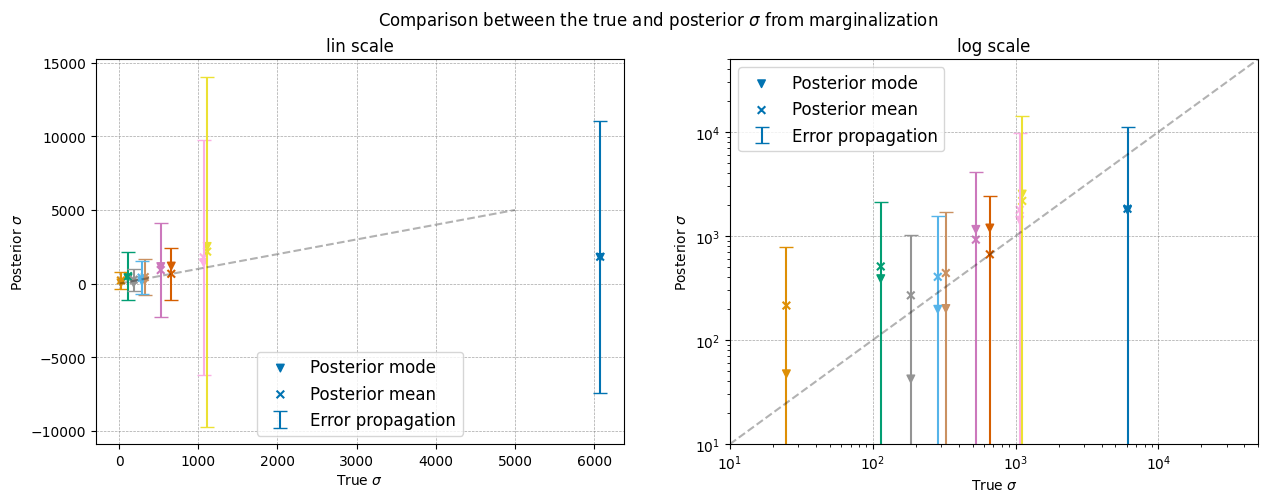

In [45]:
plt.figure(figsize=(15, 5))
plt.suptitle(r"Comparison between the true and posterior $\sigma$ from marginalization")

colors = sns.color_palette("colorblind", n_colors=len(sigma_true))

plt.subplot(121)
plt.title("lin scale")
plt.scatter(sigma_true, sigma_posterior_mode, marker="v", s=30,  label=f"Posterior mode", color=colors)
plt.scatter(sigma_true, sigma_posterior_mean, marker='x', s=30, label=f"Posterior mean", color=colors)
for i in range(n_trials):
    if i == 0: plt.errorbar(sigma_true[i], sigma_posterior_mean[i], yerr=sigma_err[i], fmt=' ', capsize = 5, ecolor=colors[i], label="Error propagation")
    else: plt.errorbar(sigma_true[i], sigma_posterior_mean[i], yerr=sigma_err[i], fmt=' ', capsize = 5, ecolor=colors[i])

plt.plot([10, 5e3], [10, 5e3], color='black', linestyle='--', alpha=0.3)

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
plt.xlabel(r"True $\sigma$")
plt.ylabel(r"Posterior $\sigma$")
plt.legend(fontsize=12)


plt.subplot(122)
plt.title("log scale")
plt.scatter(sigma_true, sigma_posterior_mode, marker="v", s=30,  label=f"Posterior mode", color=colors)
plt.scatter(sigma_true, sigma_posterior_mean, marker='x', s=30, label=f"Posterior mean", color=colors)
for i in range(n_trials):
    if i == 0: plt.errorbar(sigma_true[i], sigma_posterior_mean[i], yerr=sigma_err[i], fmt=' ', capsize = 5, ecolor=colors[i], label="Error propagation")
    else: plt.errorbar(sigma_true[i], sigma_posterior_mean[i], yerr=sigma_err[i], fmt=' ', capsize = 5, ecolor=colors[i])

plt.plot([10, 5e4], [10, 5e4], color='black', linestyle='--', alpha=0.3)

plt.xlim((10, 5e4))
plt.ylim((10, 5e4))
plt.xscale("log")
plt.yscale("log")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
plt.xlabel(r"True $\sigma$")
plt.ylabel(r"Posterior $\sigma$")
plt.legend(loc="upper left", fontsize=12);

In [47]:
# Print correlation between the true and the posterior sigma
print("Correlation between the true and the posterior sigma:")
print("Mode: ", np.corrcoef(sigma_true.reshape(n_trials,), sigma_posterior_mode.reshape(n_trials,))[0, 1])
print("Mean: ", np.corrcoef(sigma_true.reshape(n_trials,), sigma_posterior_mean.reshape(n_trials,))[0, 1])

Correlation between the true and the posterior sigma:
Mode:  0.5336515645025061
Mean:  0.6034702571066932


### Role of subsampling: lin vs log

In this section we investigate the role of the subsampling (of Cxx and s_redx) for a pool of combination of summary statistics. The key finding is that the best performance of the network are obtained for very short input vectors. 

(-5.0, -2.0)

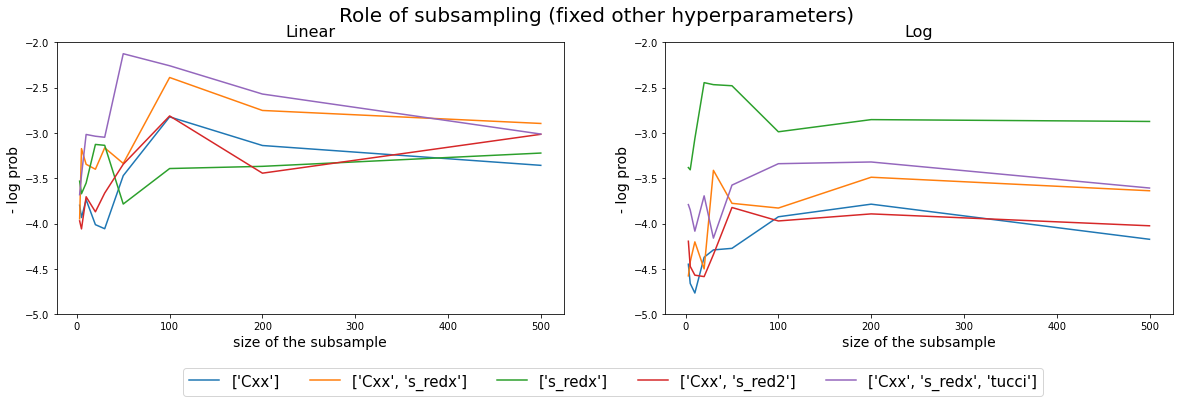

In [63]:
plt.figure(figsize=(20, 5))
plt.suptitle("Role of subsampling (fixed other hyperparameters)", fontsize=20)

with open("./data/cl_lin_results.pkl", "rb") as f: cl_lin_results = pickle.load(f)
with open("./data/cl_log_results.pkl", "rb") as f: cl_log_results = pickle.load(f)
stats = [["Cxx"], ["Cxx", "s_redx"], ["s_redx"], ["Cxx", "s_red2"], ["Cxx", "s_redx", "tucci"]]
cl_sizes = [3, 5, 10, 20, 30, 50, 100, 200, 500]

plt.subplot(121)
plt.title("Linear", fontsize=16)
for i in range(len(stats)):
    plt.plot(cl_sizes, cl_lin_results[i], label=stats[i])
plt.ylabel("- log prob", fontsize=14)
plt.xlabel("size of the subsample", fontsize=14)
plt.ylim((-5, -2))
plt.legend(ncol=len(stats), loc=(0.25, -0.3), fontsize=15)

plt.subplot(122)
plt.title("Log", fontsize=16)
for i in range(len(stats)):
    plt.plot(cl_sizes, cl_log_results[i])
plt.ylabel("- log prob", fontsize=14)
plt.xlabel("size of the subsample", fontsize=14)
plt.ylim((-5, -2))

### MSE vs NN performance

Here we investigate the correlation between the mean squared error (in the $\sigma$ reconstruction) and the performance of the SBI network. This is also the most complete comparison between set of summary statistics.

In [12]:
# Open the file
with open("../Scripts/comparisonMSE3.pkl", "rb") as f:
    comparison = pickle.load(f)

selected_stats_set = comparison["stats"]
print(selected_stats_set)
# results[i] = [nn_performance, mse_mean, mse_mode]

[['theta'], ['tucci', 'ts_psdx'], ['tucci'], ['Cxx'], ['Cxx_fit'], ['Cxx', 'tucci'], ['s_redx', 'tucci'], ['s_redx'], ['s_redx_fit'], ['s_redx', 'Cxx'], ['s_redx_fit', 'Cxx_fit'], ['s_redx_fit', 'Cxx'], ['s_redx', 'Cxx_fit']]


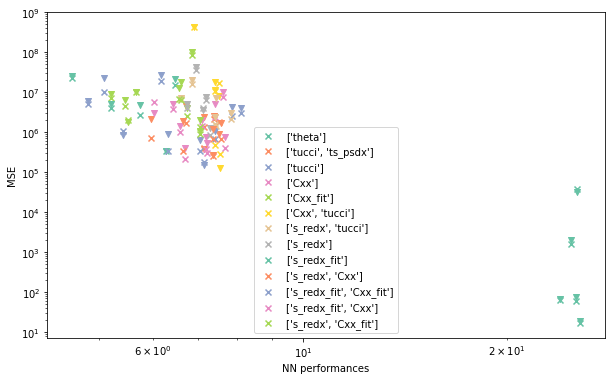

In [13]:
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Set2", len(selected_stats_set))
for i in range(len(selected_stats_set)):
    selected_stats = selected_stats_set[i]
    data = comparison[i]
    plt.scatter(data[0], data[1], label=str(selected_stats), marker="x", color=colors[i])
    plt.scatter(data[0], data[2], marker="v", color=colors[i])

plt.xscale("log")
plt.yscale("log")
#plt.xlim(0, 10)
#plt.ylim(0, 1e7)
plt.xlabel("NN performances")
plt.ylabel("MSE")
plt.legend()

### Sample size

Here we analyze the role of the sample size (number of simulations) in the performance of the network and in the $\sigma$ reconstruction

In [10]:
# Open the file
with open("../Scripts/comparisonSampleSize.pkl", "rb") as f:
    results = pickle.load(f)

selected_stats_set = results["stats"]
sample_sizes = results["sizes"]
print(selected_stats_set)

[['Cxx'], ['Cxx', 's_redx']]


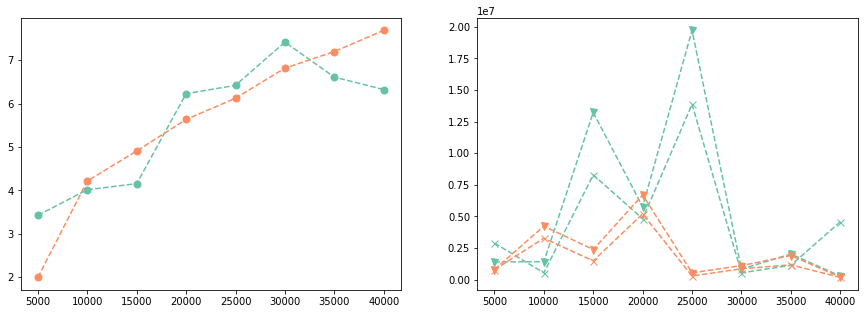

In [30]:
plt.figure(figsize=(15, 5))
colors = sns.color_palette("Set2", 2)
plt.subplot(121)
for i in range(len(selected_stats_set)):
    plt.plot(sample_sizes, results[i][0], color=colors[i], marker="o", linestyle="--", ms=7)

plt.subplot(122)
for i in range(len(selected_stats_set)):
    plt.plot(sample_sizes, results[i][1], color=colors[i], marker="x", linestyle="--", ms=7)
    plt.plot(sample_sizes, results[i][2], color=colors[i], marker="v", linestyle="--", ms=7)



## Comparison between analytical and empirical sigma

In this section, you can find the comparison "a priori" between the theoretical (analytical) entropy production and the one obtained from the traces (empirical).

For the empirical entropy, the forces in the \(x\)- and \(y\)-directions are computed as:
\begin{align*}
F_x(t) &= -k_x x(t) + k_{int} y(t) \\
F_y(t) &= -k_y y(t) + k_{int} x(t) + f(t)
\end{align*}

The discretized forces are approximated as:
\begin{align*}
F_x^s(t) &= \frac{F_x(t + \Delta t) + F_x(t)}{2 \Delta t} \\
F_y^s(t) &= \frac{F_y(t + \Delta t) + F_y(t)}{2 \Delta t}
\end{align*}

The entropy production for the \(x\)- and \(y\)-directions is given by:
\begin{align*}
S_x &= \langle (x(t + \Delta t) - x(t)) \cdot F_x^s(t) \rangle \\
S_y &= \langle (y(t + \Delta t) - y(t)) \cdot F_y^s(t) \rangle
\end{align*}

The total entropy production is:
$$
S = S_x + S_y
$$

In [9]:
%%time
# Compute the obtained entropy production priors, individually for each simulation
emp_sigma_from_prior = np.array([])
sigma_from_prior = np.array([])

# n_sim = int(1e4)
# n_batch = int(1e2)

n_sim = int(1e2)
n_batch = int(1e1)

print("Computing %d simulations in %d batches" % (n_batch*(n_sim//n_batch), n_sim//n_batch))
for i in tqdm(range(n_sim//n_batch)):
    # Simulate the dynamics
    theta, theta_torch = get_theta_from_prior(prior_limits, n_sim//n_batch)
    x_trace, y_trace, f_trace = Simulator_noGPU(dt, DeltaT, TotalT, theta)

    # Compute the empirical entropy production
    _, _, _, emp_sigma = ComputeEmpiricalEntropy(x_trace, y_trace, f_trace, theta, n_batch, DeltaT)
    emp_sigma_from_prior = np.concatenate((emp_sigma_from_prior, emp_sigma))

    # Compute the analytical entropy production
    sigma_vec, _ = ComputeTheoreticalEntropy(theta, n_batch)
    sigma_from_prior = np.concatenate((sigma_from_prior, np.squeeze(sigma_vec)))

    # Clear the memory (for safety)
    #del theta, theta_torch, prior_box, x_trace, f_trace, y_trace
    #del emp_sigma_vec, sigma_vec

Computing 100 simulations in 10 batches


100%|██████████| 10/10 [04:25<00:00, 26.52s/it]

CPU times: total: 4min 24s
Wall time: 4min 25s


In [15]:
print(np.corrcoef(emp_sigma_from_prior, sigma_from_prior)[0, 1])

0.9866104002572247


### Correlation and dependence on number of points

In [8]:
%%time
# compute the empirical and the analytical entropy for different lenghts of the trajectories (different TotalT)
n_sim = int(1e2)
n_batch = int(1e1)
TotalT = 13
correllation = []

# Simulate the dynamics
for j in np.arange(0,TotalT, 0.5):
    emp_sigma_from_prior = np.array([])
    sigma_from_prior = np.array([])
    for i in tqdm(range(n_sim//n_batch)):
        theta, theta_torch = get_theta_from_prior(prior_limits, n_sim//n_batch)
        x_trace, y_trace, f_trace = Simulator_noGPU(dt, DeltaT, j, theta)
        # compute the empirical entropy production
        _, _, _, emp_sigma = ComputeEmpiricalEntropy(x_trace, y_trace, f_trace, theta, n_batch, DeltaT)
        emp_sigma_from_prior = np.concatenate((emp_sigma_from_prior, emp_sigma))
        # compute the analytical entropy production
        sigma_vec, _ = ComputeTheoreticalEntropy(theta, n_batch)
        sigma_from_prior = np.concatenate((sigma_from_prior, np.squeeze(sigma_vec)))
    # compute the correlation
    corr = np.corrcoef(emp_sigma_from_prior, sigma_from_prior)[0, 1]
    correllation.append(corr)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:03<00:00,  2.82it/s]
c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 10/10 [08:19<00:00, 49.91s/it]

CPU times: total: 1h 40min 14s
Wall time: 1h 40min 26s


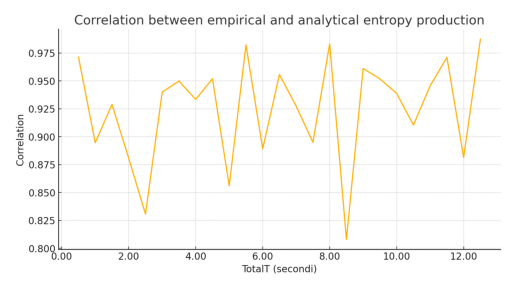

In [ ]:
image = Image.open(r'')
plt.imshow(image)
plt.axis('off')
plt.show()

In [14]:
%%time
# compute the empirical and the analytical entropy for different lenghts of the trajectories (different TotalT)
n_sim = int(1e2)
n_batch = int(1e1)
TotalT = 0.2
correllation = []

# Simulate the dynamics
for j in np.arange(0.01,TotalT, 0.01):
    emp_sigma_from_prior = np.array([])
    sigma_from_prior = np.array([])
    for i in tqdm(range(n_sim//n_batch)):
        theta, theta_torch = get_theta_from_prior(prior_limits, n_sim//n_batch)
        x_trace, y_trace, f_trace = Simulator_noGPU(dt, DeltaT, j, theta)
        # compute the empirical entropy production
        _, _, _, emp_sigma = ComputeEmpiricalEntropy(x_trace, y_trace, f_trace, theta, n_batch, DeltaT)
        emp_sigma_from_prior = np.concatenate((emp_sigma_from_prior, emp_sigma))
        # compute the analytical entropy production
        sigma_vec, _ = ComputeTheoreticalEntropy(theta, n_batch)
        sigma_from_prior = np.concatenate((sigma_from_prior, np.squeeze(sigma_vec)))
    # compute the correllation
    corr = np.corrcoef(emp_sigma_from_prior, sigma_from_prior)[0, 1]
    correllation.append(corr)

100%|██████████| 10/10 [00:02<00:00,  3.35it/s]

CPU times: total: 29.8 s
Wall time: 29.9 s


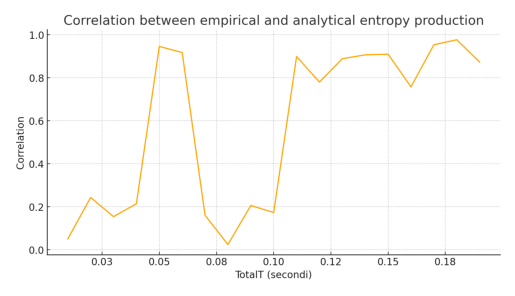

In [ ]:
image = Image.open(r'')
plt.imshow(image)
plt.axis('off')
plt.show()

Increasing the number of points, the correlation does not seem to show an increasing trend within the range we are working with.\
However, it appears to be more stable with larger TotalT, as we have fewer extremely low or high values, and we achieve correlation values above 0.95.\
There could be a minimum number of points required, but this is less than those sampled in 1 second.

In [58]:
import os

if not os.path.exists('data'):
    os.makedirs('data')
    
action = "save"

if action == "save":
    with open("data/sigma_from_prior.pkl", 'wb') as f:
        pickle.dump(sigma_from_prior, f)

    with open("data/emp_sigma_from_prior.pkl", 'wb') as f:
        pickle.dump(emp_sigma_from_prior, f)

    with open("data/theta.pkl", 'wb') as f:
        pickle.dump(theta, f)

if action == "load":
    with open("data/sigma_from_prior.pkl", 'rb') as f:
        sigma_from_prior = pickle.load(f)

    with open("data/emp_sigma_from_prior.pkl", 'rb') as f:
        emp_sigma_from_prior = pickle.load(f)

    with open("data/theta.pkl", 'rb') as f:
        theta = pickle.load(f)

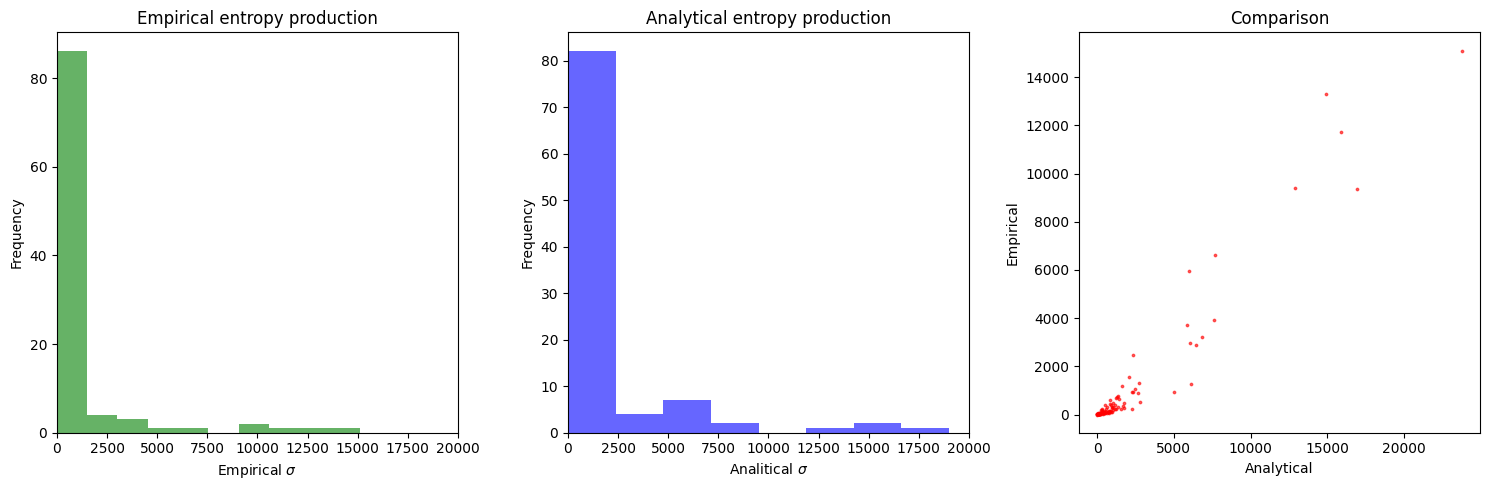

In [22]:
# do a figure with 3 subplots, 1 hist for empirical, 1 for analytical, 1 for the difference
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(emp_sigma_from_prior, bins=int(np.sqrt(len(sigma_from_prior))),alpha=0.6, color='g')
ax[0].set_xlim(0, 2e4)
ax[0].set_title("Empirical entropy production")
ax[0].set_xlabel(r"Empirical $\sigma$")
ax[0].set_ylabel("Frequency")
ax[1].hist(sigma_from_prior, bins=int(np.sqrt(len(sigma_from_prior))),alpha=0.6, color='b')

ax[1].set_title("Analytical entropy production")
ax[1].set_xlabel(r"Analitical $\sigma$")
ax[1].set_ylabel("Frequency")
ax[1].set_xlim(0,2e4)
ax[2].scatter(sigma_from_prior, emp_sigma_from_prior, alpha=0.6, color='r', s=3)
ax[2].set_title("Comparison")
ax[2].set_xlabel("Analytical")
ax[2].set_ylabel("Empirical")
plt.tight_layout()



The histograms show that the values of Both empirical and analytical produce the same results in the expected range $(5-70) \times 10^2$ (pN nm)/s.\
Also they correlate a lot, and in approximation can be used as equivalent 

In [12]:
corr = np.corrcoef(sigma_from_prior, emp_sigma_from_prior)
print("Correlation between the empirical and the analytical entropy production: ", corr[0, 1])

Correlation between the empirical and the analytical entropy production:  0.9658072013675296


## Minor analyses

### Vertical slice variance check

In this check we temped to investigate the variance of the traces along simulations obtained for the same set of parameters. The idea is to test if the simulator is stable

In [32]:
dt = 1e-6# The time step size for the simulation. This is the amount of time that passes in the model for each step of the simulation
Sample_frequency = 25_000 # The sampling frequency. This is the number of samples that are recorded per unit time
DeltaT = 1/Sample_frequency # The sampling period. This is the amount of time that passes in the model between each sample that is recorded
TotalT = 6 # The total time for the simulation. This is the total amount of time that the simulation is intended to represent
transient = 3
t_corr = TotalT/50

# n_sim = int(10)

time_steps_amount = np.int64((TotalT-transient)/dt) # Number of steps
sampled_point_amount = np.int64((TotalT-transient)/DeltaT) # Number of sampled points
sampling_delta_time_steps = np.int64(DeltaT/dt) # Number of steps between samples
t = np.linspace(0., TotalT - transient, sampled_point_amount) # Time array
# Limits for the parameters (kbT=3.8 pN nm)
prior_limits = {
    "mu_y": [1e4, 140e4],
    "k_y": [1.5e-2, 30e-2],
    "k_int": [1e-3, 6e-3],
    "tau": [2e-2, 20e-2],
    "eps": [0.5, 6],
}
tnice = [DeltaT for t in range(sampled_point_amount - 1)]
# Dummy call to compile the simulator
theta, theta_torch = get_theta_from_prior(prior_limits, 1)
theta = np.repeat(theta, 100, axis=1)
x_trace, _, _ = Simulator_noGPU(dt, DeltaT, TotalT, theta, transient_time = transient);

Standard deviation of the standard deviaton of the traces 1.8221420049667358


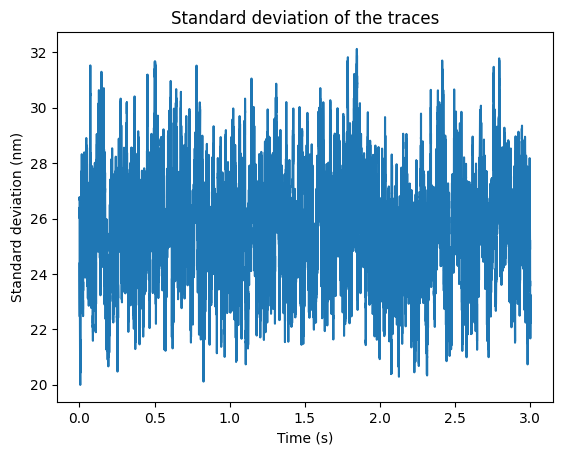

In [34]:
plt.plot(t,np.std(x_trace, axis=0));
plt.xlabel("Time (s)")
plt.ylabel("Standard deviation (nm)")
plt.title("Standard deviation of the traces")
print(f"Standard deviation of the standard deviaton of the traces {np.std(np.std(x_trace, axis=0))}")

### Typical distances in the parameters space

In this subsection we want to investigate the sampling procedure. Since there is some intrinsic stochasticity in the motion integration, SBI needs to learn to denoise the summary statistics. This works if there is some notion of locality in the space of configuration w.t.r. to the obtained summary statistics. 

In [55]:
# Load Cxx from the simulations
selected_stats = ["Cxx"] # selected summary statistics

skiped_simulations = 0
# List file in the directory SummaryStatistics
#files = os.listdir("../../Data/SummaryStatistics/20240515/")[:-1]
files = [os.path.join(root, file)
        for root, _, files in os.walk("../../Data/SummaryStatistics/")
        for file in files][1:40]
print("Reading ", len(files), " file for a total of ", 200*len(files), " simulations... \n")
loaded_simul = 0

# Pipeline from the n_sim simulations to the be ready for training
first = True
for file in files:
    print("Reading file", file, " i =", loaded_simul, " / ", 200*len(files), end='\r')
    with open(f"{file}", "rb") as f:
        summary_stats_batch = pickle.load(f)
    
    for i in range(len(summary_stats_batch)):
        # Here handle the local simulations
        summary_stats = summary_stats_batch[i]
        s_i = select_summary_statistics(summary_stats, selected_stats, DeltaT,
                z_score=False, cl_lin=-1, cl_log=-1, fit_cxx=False, fit_s_redx=False)
        
        if s_i is None: 
            skiped_simulations += 1
            print("Skiped simulations: ", skiped_simulations, end='\r')
            continue
        
        if first:
            s_tot = s_i
            theta_tot = torch.from_numpy(summary_stats["theta"]).to(torch.float32)
            first = False
        else:
            s_tot = torch.cat((s_tot, s_i), dim=0)
            theta_tot = torch.cat((theta_tot, torch.from_numpy(summary_stats["theta"]).to(torch.float32)), dim=1)
        
        loaded_simul += 1


theta_tot = theta_tot.T

# Rescale the parameters in [-0.5, 0.5] to numpy array
theta = rescale_theta(theta_tot, prior_limits).numpy()

# Get the tau of each correlation function
s_tot = s_tot.numpy()
idx_tau = np.zeros((s_tot.shape[0]))
for i, Cxx in enumerate(s_tot):
    idx_tau[i] = np.where(Cxx < Cxx[0]/np.e)[0][0]

Reading  39  file for a total of  7800  simulations... 



In [56]:
# Get the pairwise distances and the tau differences
n_sim = s_tot.shape[0]
param_distances = np.zeros(int((n_sim*(n_sim-1)/2)))
tau_diff = np.zeros(int((n_sim*(n_sim-1)/2)))

counter = 0
for i in range(n_sim):
    for j in range(i+1, n_sim):
        param_distances[counter] += np.sum((theta[i, :] - theta[j, :])**2)
        tau_diff[counter] += np.abs(idx_tau[i] - idx_tau[j])
        counter += 1

# Sort the distances
#idx = np.argsort(param_distances)
#param_distances = param_distances[idx]
#tau_diff = tau_diff[idx]

In [57]:
# Get the unbiased theoretical distribution of distances
n_trials = 1e5
th_distances = np.zeros(int(n_trials))

for i in range(int(n_trials)):
    th_distances[i] = np.sum((np.random.rand(5) - np.random.rand(5))**2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Mean tau difference')

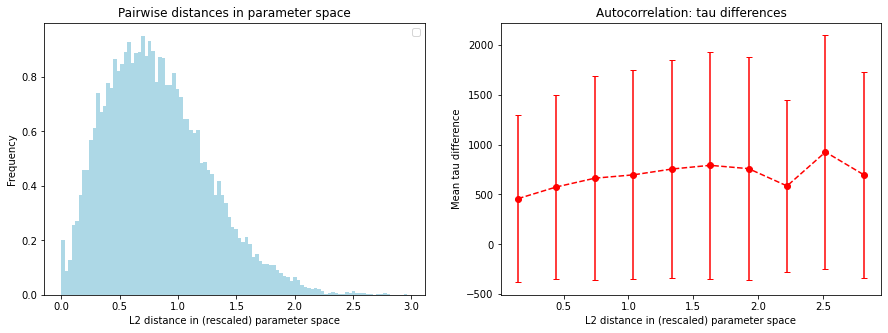

In [59]:
# Binned scatter plot
bins = np.linspace(np.min(param_distances), np.max(param_distances), 11)
bins_center = (bins[1:] + bins[:-1])/2
tau_diff_mean = np.zeros(len(bins_center))
tau_diff_std = np.zeros(len(bins_center))

for i in range(len(bins_center)):
    idx = np.where((param_distances >= bins[i]) & (param_distances < bins[i+1]))[0]
    tau_diff_mean[i] = np.mean(tau_diff[idx])
    tau_diff_std[i] = np.std(tau_diff[idx])

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("Pairwise distances in parameter space")
plt.hist(param_distances, bins=100, density=True, color="lightblue")
#kde = gaussian_kde(th_distances)
#x_range = np.linspace(np.min(th_distances), np.max(th_distances), 1000)
#plt.plot(x_range, kde(x_range), color='r', label="Theoretical unbiased curve")
plt.legend()
plt.xlabel("L2 distance in (rescaled) parameter space")
plt.ylabel("Frequency")

plt.subplot(122)
plt.title("Autocorrelation: tau differences")
plt.errorbar(bins_center, tau_diff_mean, yerr=tau_diff_std, fmt='o--', color='r', capsize=3)
plt.xlabel("L2 distance in (rescaled) parameter space")
plt.ylabel("Mean tau difference")